### 코로나 일일 확진자와 영양제/다이어트식품 검색량에 관계가 있는지 알아보자 

#### 설정 

In [1]:
import numpy as np
import pandas as pd
import copy
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import font_manager, rc
font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/NanumGothic.ttf").get_name()
rc('font', family=font_name)

#### 기본 파일 불러오기

In [2]:

#검색량 데이터 가져오기 
df_result = pd.read_csv("data/search_result.csv", encoding = "utf-8-sig",index_col= 0 )
#코로나 확진자 데이터 가져오기 
covid = pd.read_csv("data/Covid19InfState.csv", encoding = "utf-8-sig")

#### 검색량 데이터 처리 

1. 상대값에서 절댓값으로 변환

In [3]:
df_realvalue = df_result.iloc[:,1:]
scaler = 2258.17661650362
df_realvalue = round(df_realvalue*scaler, 1)
df_realvalue.insert(0, "date", df_result["date"])

#### 코로나 데이터 처리 
1. 필요한 컬럼만 가져오기(날짜, 누적확진자 수 ) 
2. 검색량 데이터랑 date 형태 맞추기 
3. 누적확진자수로 일일 확진자 수 구하기 

In [4]:
#필요한 컬럼만 가져오기
#stateDt:날짜, decideCnt:누적 확진자 수 
covid = covid[["stateDt", "decideCnt"]]
covid["stateDt"] = covid.astype(str) 

#covid trend 데이터의 date 형식을 df_nut_2020, df_food_2020과 맞추기 (yyyy-mm-dd)
covid["stateDt"] = covid["stateDt"].apply(lambda x : x[0:4]+"-"+x[4:6]+"-"+x[6:])
covid = covid.rename(columns={"stateDt" : "date"})

In [5]:
# 누적 확진자수 decideCnt를 일간 확진자수 daycnt로 변환
# 현재 누적 확진자 수에서 직전 확진자 수를 뺌 
#비정상적인 값 처리 (누적 확진자 수인데 해당일의 다음날보다 많은 이상한 값이 존재해서 이전일, 다음일의 평균으로 처리 )

daycnt = [0]
decidecnt= covid["decideCnt"]
decidecnt.fillna(0)
decidecnt.loc[3] = (decidecnt.loc[2] + decidecnt.loc[4])/2
decidecnt.loc[116] = (decidecnt.loc[115] + decidecnt.loc[117])/2
decidecnt.loc[347] = (decidecnt.loc[346] + decidecnt.loc[348])/2

decidecnt = list(decidecnt)

for i in range(1, len(decidecnt)) : 
    daycnt.append(decidecnt[i] - decidecnt[i-1])

covid["daycnt"] = daycnt 

C:\Users\zadki\Anaconda3\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


#### 검색량 데이터 구분
- 현재 검색량 데이터에는 영양제에 해당하는 카테고리와 다이어트식품에 해당하는 카테고리가 다 들어가있음
- 이를 구분하여 두 개의 데이터프레임으로 만드는 과정 
- 기존의 네이버 쇼핑 데이터에서 카테고리 값을 가져와서 해당 카테고리 값이랑 일치하는 것만 남기는 방식으로 처리 
- 이 과정에서, 네이버 데이터랩 크롤링시 제외하였던 카테고리들은 삭제함 

In [6]:
nutrients = pd.read_csv("data/nutrients_data_complete.csv", encoding = "utf_8_sig", index_col = 0)
healthfood = pd.read_csv("data/healthfood_data_complete.csv", encoding = "utf_8_sig", index_col = 0)

In [7]:
#기타 비타민, 기타 영양제, 기타 건강식품은 네이버 데이터랩 검색어에서 제외하였음
#실수로 영양제에 곤약을 넣어서..ㅎㅎ 제외함 
nut_list = list(nutrients["cate_5"].unique())
nut_list.remove("기타비타민")
nut_list.remove("기타영양제")
nut_list.remove("곤약")
food_list = list(healthfood["cate_4"].unique())
food_list.remove("기타건강식품")

In [8]:
df_nut = df_realvalue[nut_list]
df_nut["date"] = df_realvalue["date"]
df_nut = df_nut.set_index("date")
df_nut["nut_sum"] = df_nut.sum(axis=1)
df_food = df_realvalue[food_list]
df_food["date"] = df_realvalue["date"]
df_food = df_food.set_index("date")
df_food["food_sum"] = df_food.sum(axis=1)

df_nut = df_nut.reset_index()
df_food = df_food.reset_index()

C:\Users\zadki\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\zadki\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


#### 추가 처리. 2020년 1월 1일부터 보려고 slicing 

In [9]:
#2020년 1월 1일부터 보려고 slicing 함
df_nut_2020 = df_nut[df_nut["date"] >= "2020-01-01"]
df_food_2020 = df_food[df_food["date"] >= "2020-01-01"]

#그리고 total_trend로 합침 
total_trend  = pd.merge(left = df_nut_2020, right = df_food_2020, on ="date")
total_trend = pd.merge(left=total_trend, right=covid[["date", "daycnt"]], 
                       on="date", how="outer")

#### 영양제 총 검색량 / 다이어트식품 총 검색량과 코로나 일일 확진자 수의 그래프 그리기 
#### 왼쪽 : 영양제 - 코로나  /  오른쪽 : 다이어트식품 - 코로나

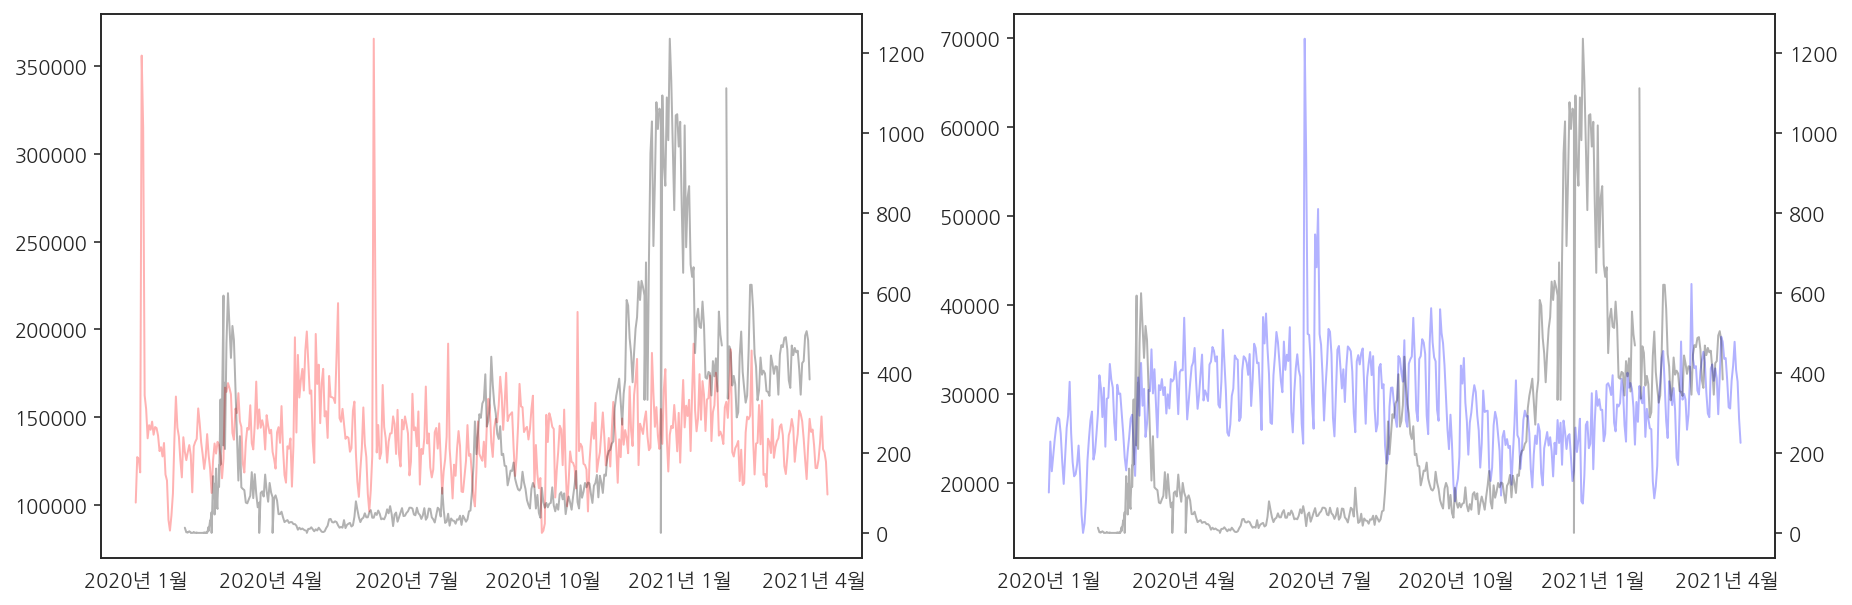

In [10]:
sns.set_style("white")
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams['font.family'] = 'NanumGothic'

plt.figure(figsize=(15,5))

ax1 = plt.subplot(121)
ax2 = ax1.twinx()
plot1 = ax1.plot(total_trend["date"], total_trend["nut_sum"], "-", color='red', lw=1, alpha=0.3)
plot2 = ax2.plot(total_trend["date"], total_trend["daycnt"], "-", color='black', lw=1, alpha=0.3)
plt.xticks(["2020-01-01", "2020-04-01","2020-07-01", "2020-10-01","2021-01-01","2021-04-01"],
          labels = ["2020년 1월","2020년 4월","2020년 7월","2020년 10월",
                    "2021년 1월","2021년 4월"])

ax3 = plt.subplot(122)
ax4 = ax3.twinx()
plot3 = ax3.plot(total_trend["date"], total_trend["food_sum"], "-", color='blue', lw=1, alpha=0.3)
plot4 = ax4.plot(total_trend["date"], total_trend["daycnt"], "-", color='black', lw=1, alpha=0.3)
plt.xticks(["2020-01-01", "2020-04-01","2020-07-01", "2020-10-01","2021-01-01","2021-04-01"],
          labels = ["2020년 1월","2020년 4월","2020년 7월","2020년 10월",
                    "2021년 1월","2021년 4월"])
    

plt.show()

#### 세부 카테고리별 검색량 - 코로나 일일 확진자 수 그래프 그리기 
#### trend_graph : 검색량을 조회하고 싶은 세부 카테고리를 리스트형으로 넣으면 그래프를 그려주는 함수 

In [11]:
def trend_graph(catenames) :
    sns.set_style("white")
    plt.rcParams['axes.unicode_minus'] = False
    plt.rcParams['font.family'] = 'NanumGothic'

    fig = plt.figure(figsize=(15,5))
    ax1 = fig.add_subplot()
      
    for i, value in enumerate(catenames) : 
        plot1 = ax1.plot(total_trend["date"], total_trend[value], "-", lw=1, alpha=0.7, label = f"{value}")
        ax1.legend(loc = "upper left")
    
    ax2 = ax1.twinx()
    plot2 = ax2.plot(total_trend["date"], total_trend["daycnt"], "-", color='red', lw=1, alpha=0.3, label = "코로나 일일 확진자")
    plt.xticks(["2020-01-01", "2020-04-01","2020-07-01", "2020-10-01","2021-01-01","2021-04-01"],
          labels = ["2020년 1월","2020년 4월","2020년 7월","2020년 10월", "2021년 1월","2021년 4월"])
    ax2.legend(loc = "upper right")
    plt.show()

In [ ]:
trend_graph(["비타민D"]) ## 여기에 리스트 형태로 카테고리를 넣어주세요 

In [ ]:
total_trend.columns ## << 카테고리 목록을 확인하려면 이쪽 